Installing and Importing Libraries


In [1]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16,EfficientNetV2L,ResNet50,ResNet101
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
!pip install segmentation-models
import segmentation_models as sm
from matplotlib import pyplot as plt
import imutils
from sklearn.metrics import f1_score
import random

     |████████████████████████████████| 50 kB 7.2 MB/s 
Segmentation Models: using `keras` framework.


Mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Unziping A3_Dataset.zip folder

In [3]:
!unzip /content/drive/MyDrive/A3_Dataset.zip -d /content/

Archive:  /content/drive/MyDrive/A3_Dataset.zip
   creating: /content/A3_Dataset/
   creating: /content/A3_Dataset/dataset1/
   creating: /content/A3_Dataset/dataset1/annotations_prepped_test/
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: /content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: /content/A3_Dataset/

In [4]:
# number of training and testing examples
print(len(os.listdir('/content/A3_Dataset/dataset1/images_prepped_train')))
print(len(os.listdir('/content/A3_Dataset/dataset1/images_prepped_test')))

367
101


Custom Data Augmentation function so that label and images both get augmented

In [5]:

def custom_augmentor(img,l):
  #generate random number in range [0,180) for image and label rotation
  n=int(random.random()*1000)%180 
  image=imutils.rotate(img,n)
  label=imutils.rotate(l,n)

  #randomly decide to flip image horizontally or vertically
  n1=n%2
  image = cv2.flip(img, n1)
  label= cv2.flip(l, n1)

  #randomaly translate the image horizonatlly or vertically
  T_height_n=n=int(random.random()*10)%4+6
  T_width_n=n=int(random.random()*10)%4+6
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / T_height_n, width / T_width_n
  if(n1==0):
    T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  else:
    T = np.float32([[1, 0, -1*quarter_width], [0, 1, -1*quarter_height]])
  image = cv2.warpAffine(image, T, (width, height))
  label = cv2.warpAffine(label, T, (width, height))
  
  #returning final augmented image and label
  return image,label


Loading Data

In [6]:
def load_dataset():
  train_images=[]
  train_labels=[]
  test_images=[]
  test_labels=[]

  #loading all the training examples from the folder
  for images in os.listdir('/content/A3_Dataset/dataset1/images_prepped_train'):
    img=cv2.imread('/content/A3_Dataset/dataset1/images_prepped_train/'+images)
    ann=cv2.imread('/content/A3_Dataset/dataset1/annotations_prepped_train/'+images)

    #resizing all the examples to 352x480
    img=cv2.resize(img,(480,352))
    ann=cv2.resize(ann,(480,352))
    img=np.asarray(img)
    ann=np.asarray(ann)

    #converting labels to 1 channel (gray scale) image
    ann=cv2.cvtColor(ann,cv2.COLOR_BGR2GRAY)
    train_images.append(img)
    train_labels.append(ann)

  #loading all the test examples from the folder
  for images in os.listdir('/content/A3_Dataset/dataset1/images_prepped_test'):
    img=cv2.imread('/content/A3_Dataset/dataset1/images_prepped_test/'+images)
    ann=cv2.imread('/content/A3_Dataset/dataset1/annotations_prepped_test/'+images)

    #resizing all the examples to 352x480
    img=cv2.resize(img,(480,352))
    ann=cv2.resize(ann,(480,352))
    ann=cv2.cvtColor(ann,cv2.COLOR_BGR2GRAY)
    img=np.asarray(img)
    ann=np.asarray(ann)
    test_images.append(img)
    test_labels.append(ann)


  #augmenting data examples

  for j in range(0,len(train_images)):
      aug_image,aug_label=custom_augmentor(train_images[j],train_labels[j])
      train_images.append(aug_image)
      train_labels.append(aug_label)

  train_images=np.asarray(train_images)
  train_labels=np.asarray(train_labels)
  test_images=np.asarray(test_images)
  test_labels=np.asarray(test_labels)

  return train_images,train_labels,test_images,test_labels



Preprocessing Data

In [7]:
def preprocessing_images(X):
  X=np.asarray(X)

  #image normalization
  X=X/255
  X=X.astype(np.float)
  return X
def preprocessing_labels(X):
  X=np.asarray(X)
  X=X.astype(np.float)
  
  #one hot encoding the labels
  X=to_categorical(X,num_classes=12)
  return X

Model loading and compilation

In [8]:
def UNET_model(BACKBONE):
  preprocess_input = sm.get_preprocessing(BACKBONE)

  #loading pretrained weights
  #using softmax activation
  #freezing all layers of encoder
  model = sm.Unet(BACKBONE, encoder_weights='imagenet',activation='softmax',classes=12,input_shape=((352,480,3)),encoder_freeze=True)

  #compile model
  model.compile(
    'adam',
    loss=sm.losses.categorical_crossentropy,
    metrics=[sm.metrics.FScore(threshold=0.5),sm.metrics.iou_score,'accuracy']
  )
  model.summary()
  return model



Userdefined evaluation metrics

In [9]:
import keras.backend as K

# Calculating dice coefficient
def dice_coeff(y_true,y_pred,smooth=1):
  intersection=K.sum(y_true*y_pred,axis=[1,2,3])
  union=K.sum(y_true,axis=[1,2,3])+K.sum(y_pred,axis=[1,2,3])
  dice=K.mean((2.*intersection+smooth)/(union+smooth))
  return dice

# Calculating Sensitivty
def sensitivity(y_true,y_pred):
  TP=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  PP=K.sum(K.round(K.clip(y_true,0,1)))
  return TP/(PP+K.epsilon())

#Calculating Specificity
def specificity(y_true,y_pred):
  TN=K.sum(K.round(K.clip((1-y_true)*(1-y_pred),0,1)))
  NN=K.sum(K.round(K.clip((1-y_true),0,1)))
  return TN/(NN+K.epsilon())

Setting framework to tensorflow.keras

In [10]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

Complete Pipeline

In [11]:
#loading train dataset
train_images,train_labels,test_images,test_labels=load_dataset()

#preprocessing of data
train_images=preprocessing_images(train_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [12]:
#preprocessing labels
train_labels=preprocessing_labels(train_labels)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [13]:
#size of Dataset after augmentation and preprocessing
print(train_images.shape)
print(train_labels.shape)

(734, 352, 480, 3)
(734, 352, 480, 12)


Model training: UNET EfficientNet backbone

In [14]:
#segmentation model
# "efficientnetb0" or "vgg16"
model=UNET_model('efficientnetb0')


16818176/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 176, 240, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 176, 240, 32  128         ['stem_conv[0][0]']              
                             

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Assignment_3_Unet_effbackbone_{epoch:03d}-{val_f1-score:.4f}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1,period=5,

                                                 )


In [ ]:
history=model.fit(
   callbacks=[cp_callback],
   x=train_images,
   y=train_labels,
   shuffle=True,
   batch_size=8,
   epochs=50,
   validation_split=0.20
    )

Epoch 1/50
74/74 [==============================] - 33s 309ms/step - loss: 0.0800 - f1-score: 0.2664 - iou_score: 0.2010 - accuracy: 0.7458 - val_loss: 0.1773 - val_f1-score: 0.2511 - val_iou_score: 0.1840 - val_accuracy: 0.6442
Epoch 2/50
74/74 [==============================] - 19s 253ms/step - loss: 0.0445 - f1-score: 0.4127 - iou_score: 0.3167 - accuracy: 0.8500 - val_loss: 0.0853 - val_f1-score: 0.3288 - val_iou_score: 0.2418 - val_accuracy: 0.7317
Epoch 3/50
74/74 [==============================] - 19s 252ms/step - loss: 0.0386 - f1-score: 0.4286 - iou_score: 0.3515 - accuracy: 0.8679 - val_loss: 0.0586 - val_f1-score: 0.3754 - val_iou_score: 0.2966 - val_accuracy: 0.8129
Epoch 4/50
74/74 [==============================] - 19s 252ms/step - loss: 0.0339 - f1-score: 0.4544 - iou_score: 0.3804 - accuracy: 0.8826 - val_loss: 0.0445 - val_f1-score: 0.4013 - val_iou_score: 0.3196 - val_accuracy: 0.8501
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.0317 - f1-scor

Loading Test Data (Quantitative Results)


In [17]:
test_images=preprocessing_images(test_images)
test_labels=preprocessing_labels(test_labels)
print(test_images.shape)
test_labels=np.asarray(test_labels)
print(test_labels.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


(101, 352, 480, 3)
(101, 352, 480, 12)


Evaluating model

In [18]:
label=model.predict(test_images)
acc=model.evaluate(test_images,test_labels)

4/4 [==============================] - 5s 344ms/step - loss: 0.0326 - f1-score: 0.7428 - iou_score: 0.6100 - accuracy: 0.9160


In [19]:
# calculating dice coefficient
d=dice_coeff(test_labels,label)

# calculating sensitivity
s=sensitivity(test_labels,label)

# calculating specificity
sp=specificity(test_labels,label)

#Displaying rsults
print(d)
print(s)
print(sp)



tf.Tensor(0.9022051, shape=(), dtype=float32)
tf.Tensor(0.90814644, shape=(), dtype=float32)
tf.Tensor(0.9935483, shape=(), dtype=float32)


Qualitative Results

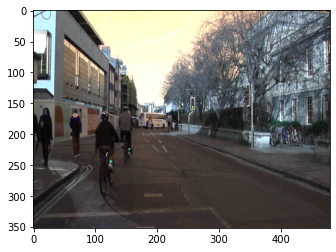

In [20]:
n=85

#displaying test image
plt.imshow(test_images[n])

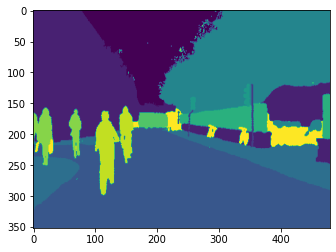

In [21]:
#display ground truth
plt.imshow(np.argmax(test_labels[n],axis=2))

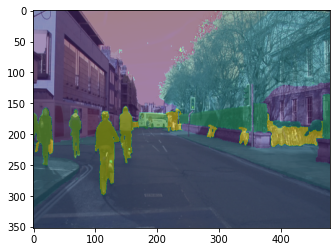

In [22]:
#ground truth superimposed on original image
fig, ax = plt.subplots()
ax.imshow(test_images[n])
ax.imshow(np.argmax(test_labels[n],axis=2), alpha=0.5)
fig.show()

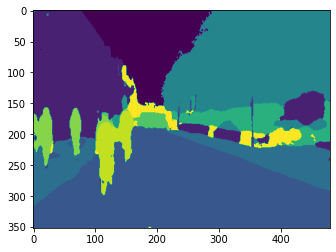

In [23]:
#predicted mask
plt.imshow(np.argmax(label[n],axis=2))

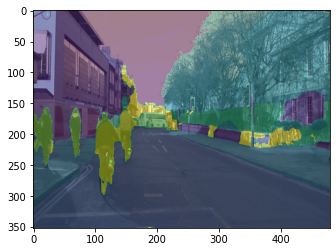

In [24]:
#predicted mask superimposed on original image
fig, ax = plt.subplots()
ax.imshow(test_images[n])
ax.imshow(np.argmax(label[n],axis=2), alpha=0.5)
fig.show()

UNET VGG16(backbone)

In [ ]:
model=UNET_model('vgg16')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Assignment_3_Unet_vggbackbone_{epoch:03d}-{val_f1-score:.4f}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1,period=5,
                                                 )

58900480/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 352, 480, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 352, 480, 64  36928       ['block1_conv1[0][0]']           
                             

In [ ]:
# training model
history=model.fit(
   callbacks=[cp_callback],
   x=train_images,
   y=train_labels,
   shuffle=True,
   batch_size=32,
   epochs=50,
   validation_split=0.20
    )

Epoch 1/50
19/19 [==============================] - 41s 1s/step - loss: 0.1479 - f1-score: 0.0970 - iou_score: 0.0833 - accuracy: 0.4913 - val_loss: 0.1815 - val_f1-score: 0.1986 - val_iou_score: 0.1353 - val_accuracy: 0.6142
Epoch 2/50
19/19 [==============================] - 14s 766ms/step - loss: 0.0772 - f1-score: 0.2539 - iou_score: 0.1808 - accuracy: 0.7659 - val_loss: 0.1295 - val_f1-score: 0.2030 - val_iou_score: 0.1447 - val_accuracy: 0.6400
Epoch 3/50
19/19 [==============================] - 14s 767ms/step - loss: 0.0571 - f1-score: 0.2972 - iou_score: 0.2421 - accuracy: 0.8111 - val_loss: 0.1932 - val_f1-score: 0.2254 - val_iou_score: 0.1621 - val_accuracy: 0.5573
Epoch 4/50
19/19 [==============================] - 14s 764ms/step - loss: 0.0485 - f1-score: 0.3548 - iou_score: 0.2802 - accuracy: 0.8375 - val_loss: 0.1440 - val_f1-score: 0.2497 - val_iou_score: 0.1822 - val_accuracy: 0.5567
Epoch 5/50
19/19 [==============================] - ETA: 0s - loss: 0.0426 - f1-score: 

Training graphs

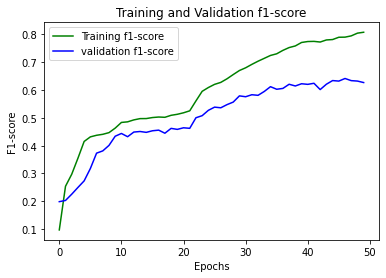

In [ ]:
acc_train = history.history['f1-score']
acc_val = history.history['val_f1-score']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training f1-score')
plt.plot(epochs, acc_val, 'b', label='validation f1-score')
plt.title('Training and Validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

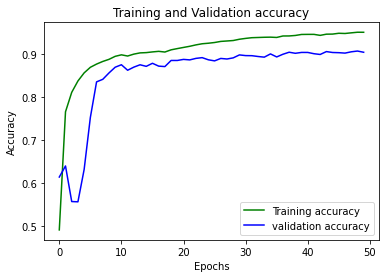

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

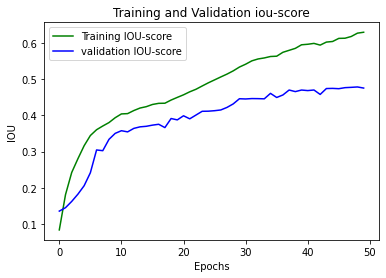

In [ ]:
acc_train = history.history['iou_score']
acc_val = history.history['val_iou_score']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training IOU-score')
plt.plot(epochs, acc_val, 'b', label='validation IOU-score')
plt.title('Training and Validation iou-score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

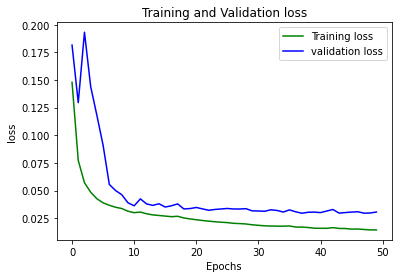

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Quantitative results

In [ ]:
label=model.predict(test_images)
acc=model.evaluate(test_images,test_labels)


4/4 [==============================] - 1s 277ms/step - loss: 0.0353 - f1-score: 0.6904 - iou_score: 0.5282 - accuracy: 0.8956


In [ ]:
# calculating dice coefficient
d=dice_coeff(test_labels,label)

# calculating sensitivity
s=sensitivity(test_labels,label)

# calculating specificity
sp=specificity(test_labels,label)

#Displaying rsults
print(d)
print(s)
print(sp)



tf.Tensor(0.8715408, shape=(), dtype=float32)
tf.Tensor(0.88051564, shape=(), dtype=float32)
tf.Tensor(0.9929909, shape=(), dtype=float32)


Qualitative Results

In [ ]:
n=40


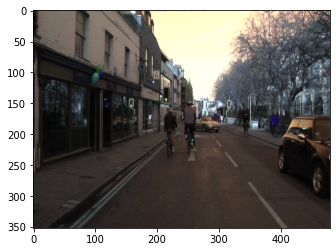

In [ ]:
# original test image
plt.imshow(test_images[n])

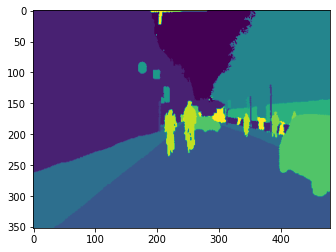

In [25]:
# ground truth mask
plt.imshow(np.argmax(test_labels[n],axis=2))

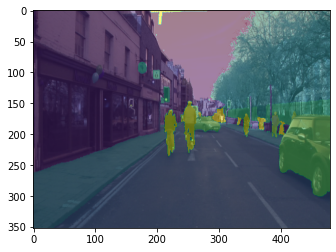

In [ ]:
# ground truth superimposed on original image
fig, ax = plt.subplots()
ax.imshow(test_images[n])
ax.imshow(np.argmax(test_labels[n],axis=2), alpha=0.5)
fig.show()

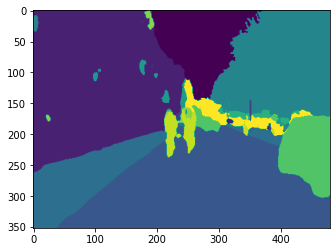

In [ ]:
# predicted mask 
plt.imshow(np.argmax(label[n],axis=2))

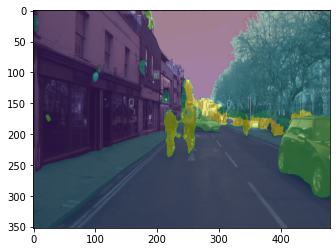

In [ ]:
# Predicted mask superimposed on original image
fig, ax = plt.subplots()
ax.imshow(test_images[n])
ax.imshow(np.argmax(label[n],axis=2), alpha=0.5)
fig.show()